In [37]:
import pandas as pd
import numpy as np
import warnings

import os

from load_wastewater_data import *
from plotting_tools import *
import seaborn as sns

# Update rcParams to set the default font to Times New Roman
plt.style.use('default')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'

In [38]:
# define experiment to be preprocessed
experiment_series = "2024_09_17"

resolution = "3_min_resolution" 
rain_scenario = "KeinRegen" # one of KeinRegen, Nieselregen, MittelstarkerRegen
degradation_setting = "no_decay" # one of "no_decay", "linear_decay_dynamics", "constant_decay_dynamics"

In [39]:
plot_path = f"../plots/wastewater_model/correlation"
os.makedirs(os.path.join(plot_path), exist_ok=True)
file_name_prefix = f"{resolution}_{rain_scenario}_{degradation_setting}"

In [40]:
df_wastewater = load_systems_data(experiment_series, resolution, rain_scenario, degradation_setting, file_type="concentrations")
df_wastewater["hours"] = df_wastewater["minutes"]/60
df_wastewater = df_wastewater[[int(x)==x for x in df_wastewater.hours]]

In [41]:
infection_model_output_path = f"../../preprocessing/preprocessed_data/infection_model/{experiment_series}"

### Find prevalence by ++systems location 

In [42]:
# Define upstream locations for three sampling points of the neighbourhood
upstream_1 = ["00083", "00084", "00085"]
upstream_2 = ["00102", "00103"] 
upstream_3 = upstream_1 + upstream_2 + ["00086", "00087"] 
upstream_4 = upstream_3 + ["00088", "00089", "00090", "00091", "00092", "00093", "00094", "00095", "00096", "00097", "00098", "00099", "00100", "00101"]
upstream_5 = ["00111", "00112", "00113", "00114", "00115", "00116", "00117", "00118", "00119", "00120", "00121", "00122", "00123", "00124", "00125", "00001", "00002", "00003", "00004", "00005", "00006"]
upstream_6 = ["00033", "00034", "00035", "00036", "00037", "00038", "00039", "00104", "00105", "00106", "00107", "00108", "00109", "00110"]
upstream_7 = upstream_4 + upstream_5 + upstream_6 + ["00007", "00008", "00009", "00010"]
upstream_8 = upstream_7 + ["00011", "00012", "00013", "00014"]
upstream_9 = ["00033", "00034", "00035", "00036", "00037", "00038", "00039"]
upstream_10 = upstream_9 + ["00040", "00041", "00042", "00043"]
upstream_11 = upstream_10 + ["00079", "00080", "00081", "00082"]
upstream_12 = upstream_8 + upstream_11 + ["00015", "00016", "00017", "00018"]
upstream_13 = ["00070", "00072", "00074", "00075", "00076", "00077", "00078"]
upstream_14 = upstream_12 + ["00019", "00020", "00021", "00022", "00023", "00024", "00025", "00026", "00027", "00028"]
upstream_15 = upstream_10 + ["00044", "00045", "00046", "00047", "00048", "00049", "00050", "00051", "00052", "00053", "00054", "00055", "00056", "00057", "00058", "00059", "00060", "00061", "00062", "00063", "00064", "00066", "00068", "00031"]
upstream_16 = upstream_13 + upstream_14 + upstream_15 + ["00029", "00030", "00032", "00069", "00067", "00065"]

upstream_locations_dict = {"1": upstream_1, "2": upstream_2, "3": upstream_3, "4": upstream_4, "5": upstream_5, "6": upstream_6, "7": upstream_7, "8": upstream_8, "9": upstream_9, "10": upstream_10, "11": upstream_11, "12": upstream_12,
                           "13": upstream_13, "14": upstream_14, "15": upstream_15, "16": upstream_16}

In [43]:
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))

def get_crosscorr(df_combined, lags_in_hours):
    df_combined = df_combined.sort_values("hours")
    return [crosscorr(df_combined["COVID_copies/l"], df_combined["I_total"], lag) for lag in lags_in_hours]

In [44]:
warnings.filterwarnings("ignore", message="An input array is constant; the correlation coefficient is not defined.")
warnings.filterwarnings("ignore", message="invalid value encountered in divide")

max_lag = 45
results = []
nas = []

for sampling_location in df_wastewater.loc[:,"sampling_point"].astype(int).sort_values().unique():
    
    upstream_locations = upstream_locations_dict[str(sampling_location)]
    loc_corr = []
    for sim in df_wastewater['memilio_id'].unique():
        
        df_agent_trajectory = pd.read_csv(f"{infection_model_output_path}/agent_trajectories/agent_trajectories_{sim}.csv", index_col=0)
        df_agent_trajectory["systems_location"] = df_agent_trajectory["systems_location"].astype(str).apply(lambda x: x.zfill(5))
        df_agent_trajectory = df_agent_trajectory.loc[df_agent_trajectory.time_since_transmission >= 0]
        df_agent_trajectory = df_agent_trajectory.loc[df_agent_trajectory.systems_location.isin(upstream_locations), :]
        df_agent_trajectory = df_agent_trajectory.groupby('time_in_hours').size().reset_index(name='I_total')
    
        curr_sim_ww = df_wastewater.loc[(df_wastewater['memilio_id'] == sim) & (df_wastewater['sampling_point'] == str(sampling_location))]
        
        curr_combined = curr_sim_ww.merge(df_agent_trajectory, left_on="hours", right_on="time_in_hours", how="left")
        curr_combined['I_total'] = curr_combined['I_total'].fillna(0)
        loc_corr.append(get_crosscorr(curr_combined, range(-max_lag, max_lag+1, 1)))
        print(sim)
    
    df_corr = pd.DataFrame(loc_corr)
    results.append(df_corr.mean(axis = 0))
    nas.append(250 - sum(df_corr.transpose().isna().sum() > 0))
    print(sampling_location)
    

112
30
38
186
163
131
165
5
78
198
185
130
203
103
27
141
95
136
84
143
2
149
42
89
128


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [9]:
df_res = pd.DataFrame(results).transpose()
df_res.columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']
df_res["lag_in_h"] = range(-max_lag, max_lag + 1, 1)
df_res = df_res.set_index("lag_in_h")

df_nas = pd.DataFrame(nas).transpose()
df_nas.columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']


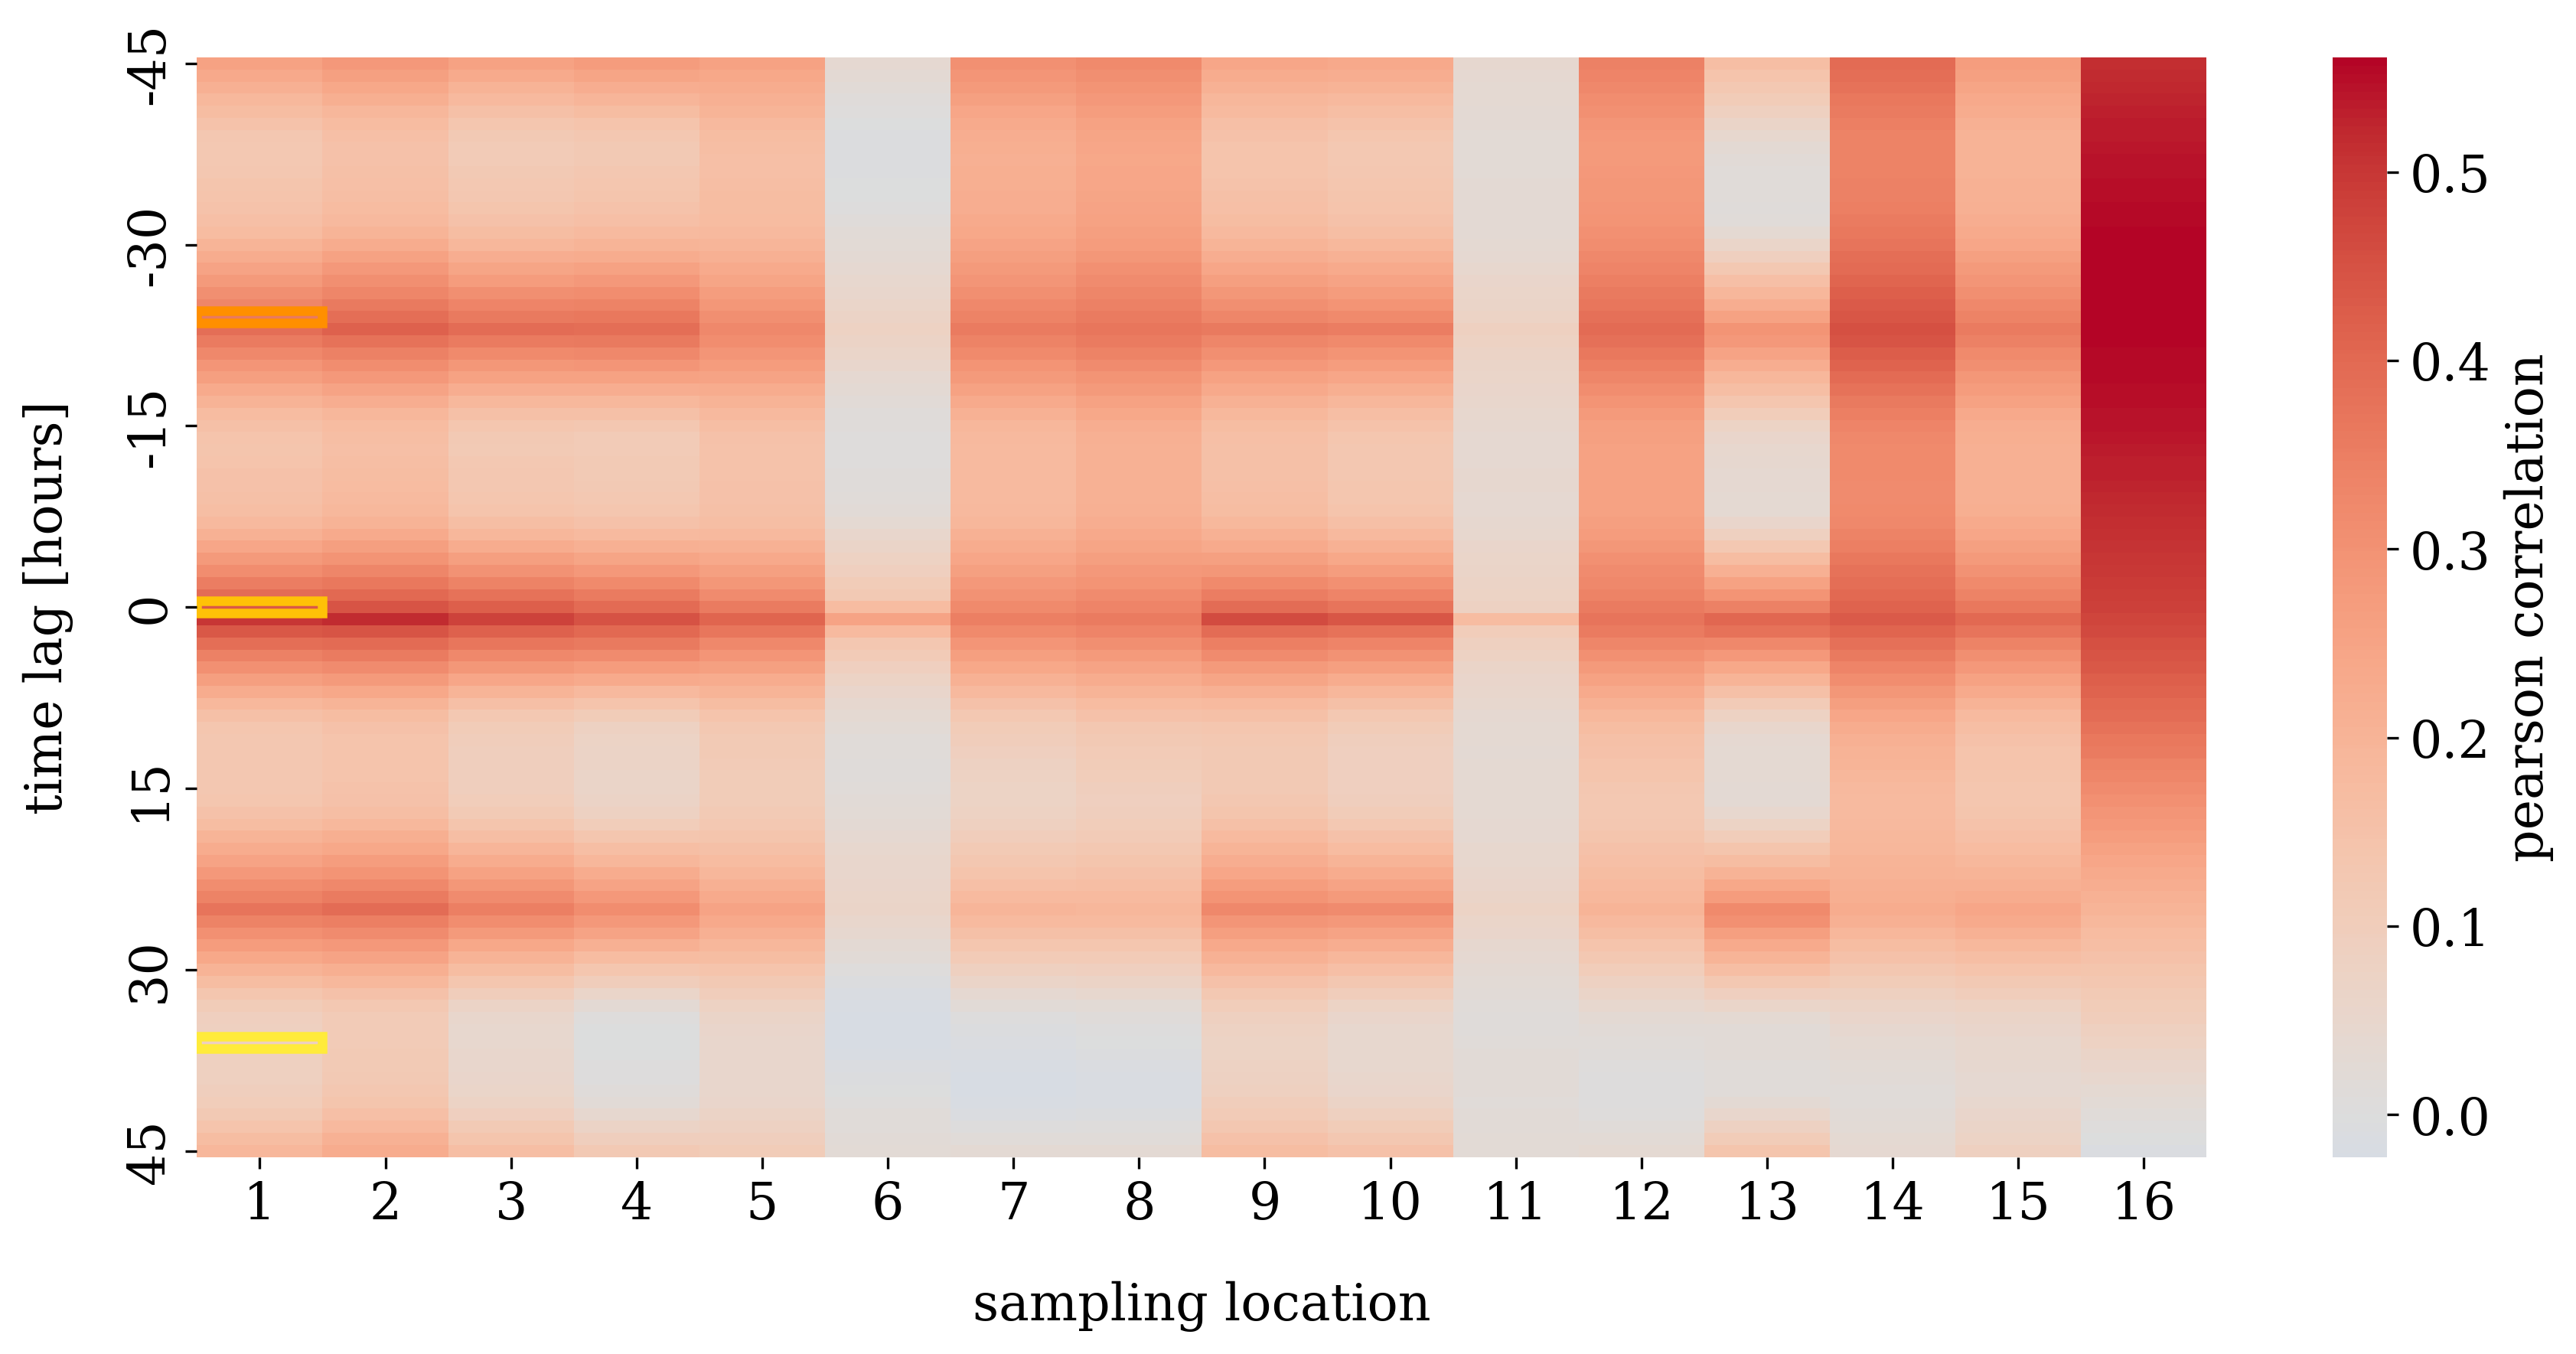

In [45]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(figsize = (12,6), dpi=300) 
lb = sns.heatmap(df_res[[str(i) for i in range(1,17)]], cmap='coolwarm', center=0, yticklabels=15, cbar_kws={'label': 'pearson correlation'})
ax.set_xlabel("sampling location", labelpad=16,fontsize=16)
ax.set_ylabel("time lag [hours]", labelpad=16,fontsize=16)
lb.figure.axes[-1].yaxis.label.set_size(16)
lb.figure.axes[-1].tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

shades_of_yellow = ['#FFEB3B', '#FFC107', '#FF8F00']
ax.add_patch(Rectangle((0, df_res.index.get_loc(-24)), 1, 1, fill=False, edgecolor=shades_of_yellow[2], lw=3))
ax.add_patch(Rectangle((0, df_res.index.get_loc(0)), 1, 1, fill=False, edgecolor=shades_of_yellow[1], lw=3))
ax.add_patch(Rectangle((0, df_res.index.get_loc(36)), 1, 1, fill=False, edgecolor=shades_of_yellow[0], lw=3))

plt.tight_layout()
fig.savefig(os.path.join(plot_path, f"{file_name_prefix}_local_cross_correlation.png"), dpi=300)

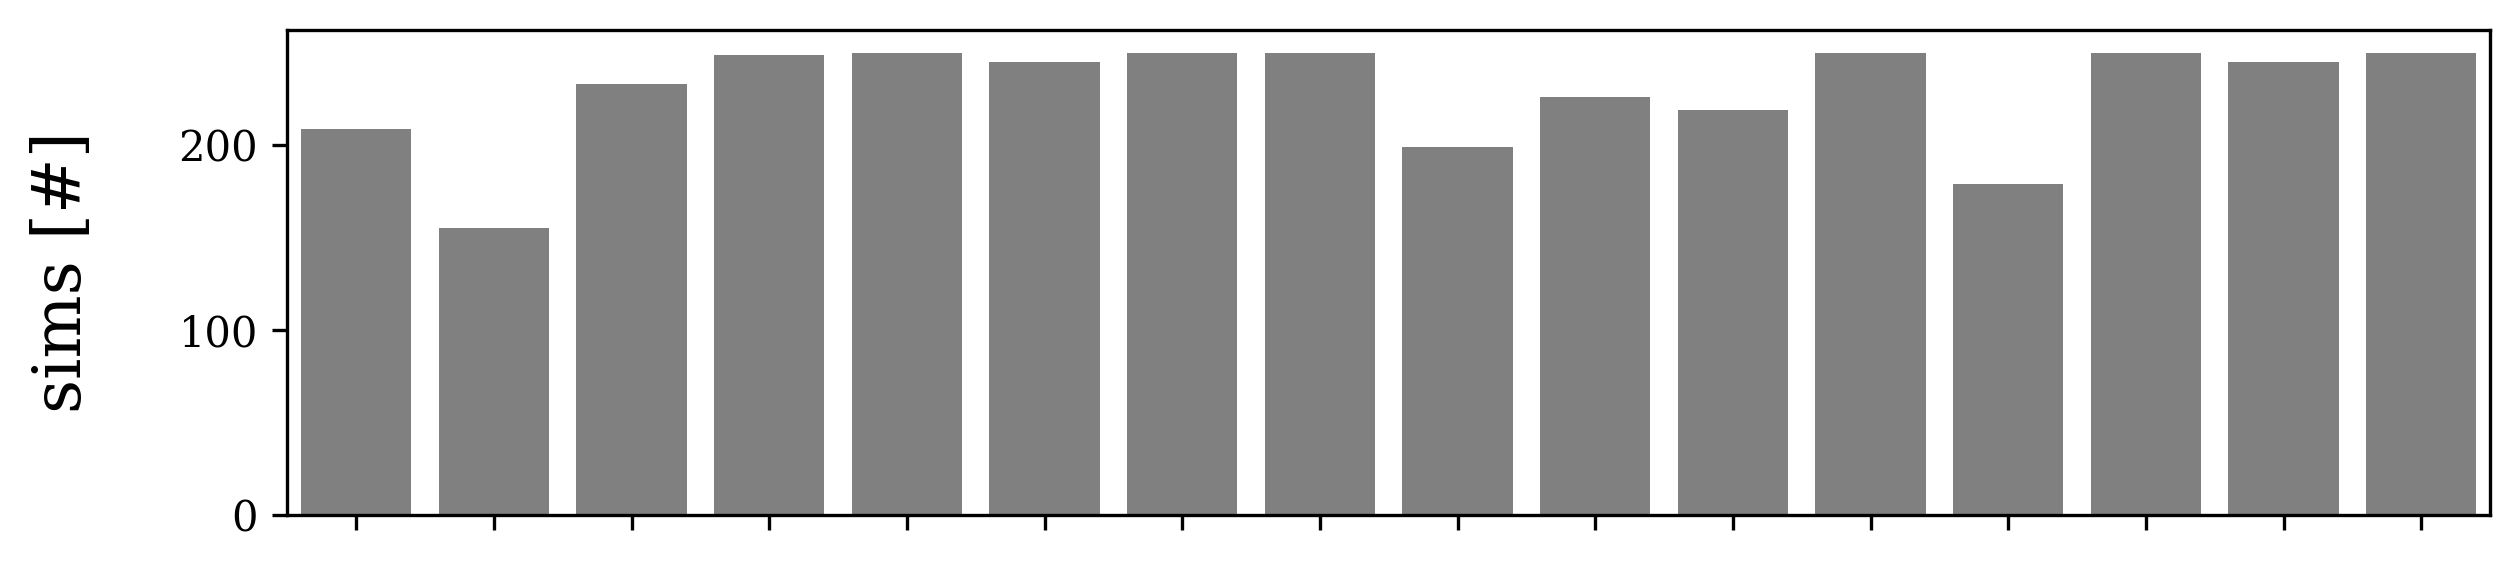

In [46]:
fig, ax = plt.subplots(figsize = (8.5,2), dpi=300) 
lb = sns.barplot(df_nas[[str(i) for i in range(1,17)]], color = "grey")
ax.set_ylabel("sims [#]", labelpad=20,fontsize=20)
lb.figure.axes[-1].yaxis.label.set_size(16)
ax.set(xticklabels=[])

plt.tight_layout()
fig.savefig(os.path.join(plot_path, f"{file_name_prefix}_local_corr_sims.png"), dpi=300)

In [47]:
sim_no = 1
station = 1

df_wastewater_avg = df_wastewater.groupby(["time_in_days", "sampling_point"]).mean().reset_index()[["time_in_days", "hours", "sampling_point", "COVID_copies/l"]]
df_wastewater_avg = df_wastewater_avg.loc[df_wastewater_avg['sampling_point'] == str(station)]

def find_upstream_prev(sim_no, station):
    upstream_locations = upstream_locations_dict[str(station)]
    df_agent_trajectory = pd.read_csv(f"{infection_model_output_path}/agent_trajectories/agent_trajectories_{sim_no}.csv", index_col=0)
    df_agent_trajectory["systems_location"] = df_agent_trajectory["systems_location"].astype(str).apply(lambda x: x.zfill(5))
    df_agent_trajectory = df_agent_trajectory.loc[df_agent_trajectory.time_since_transmission >= 0]
    df_agent_trajectory = df_agent_trajectory.loc[df_agent_trajectory.systems_location.isin(upstream_locations), :]
    df_agent_trajectory = df_agent_trajectory.groupby('time_in_hours').size().reset_index(name='I_total')
    df_agent_trajectory["memilio_id"] = sim_no
    return df_agent_trajectory

df_prev = [find_upstream_prev(sim_no, station) for sim_no in range(1, 251)]
df_prev = pd.concat(df_prev)

df_prev_avg = df_prev.groupby(["time_in_hours"])[["I_total"]].mean().reset_index()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250


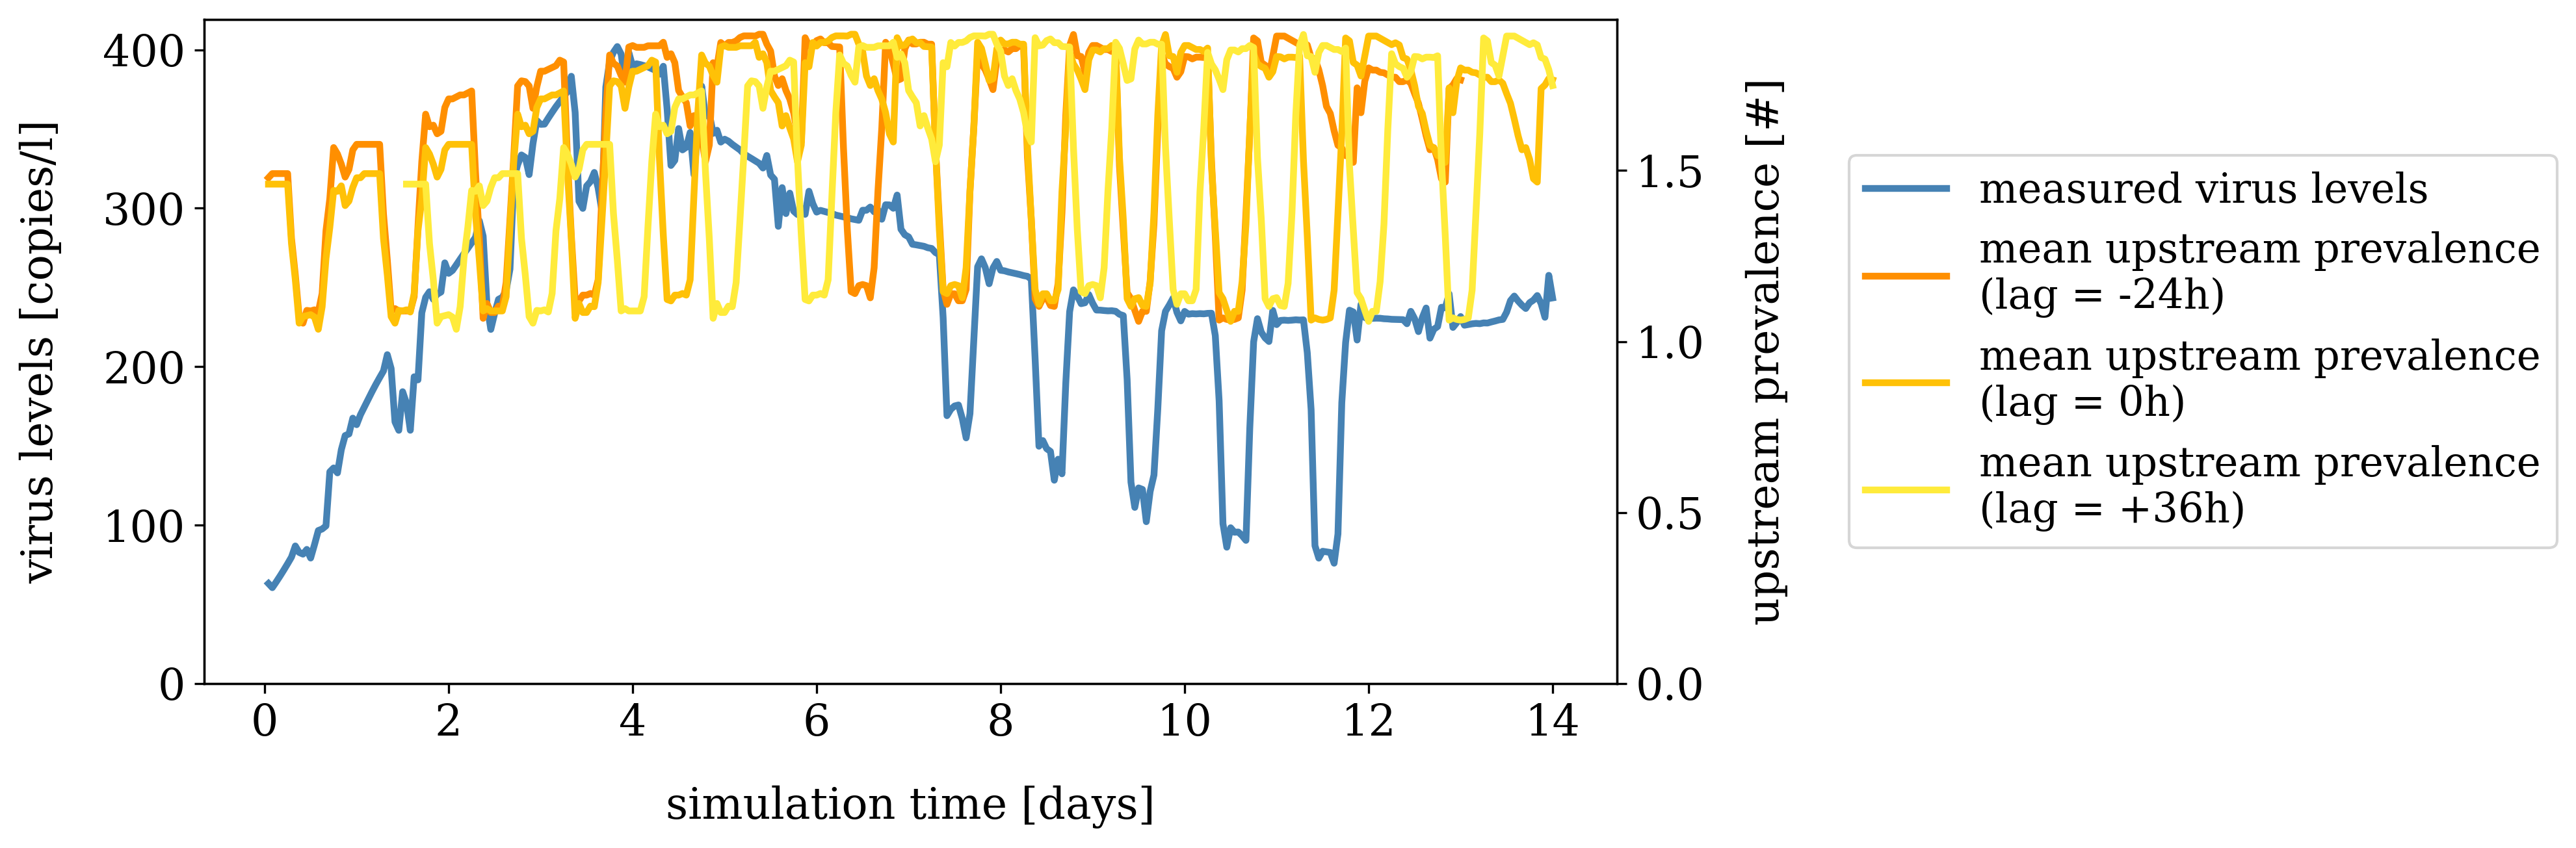

In [48]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

combined = df_wastewater_avg.merge(df_prev_avg, left_on="hours", right_on="time_in_hours", how="left")
correlations = get_crosscorr(combined, [-24, 0, 36])

combined = combined.sort_values("hours")
combined["time_in_days"] = combined["hours"]/24
combined["time_in_days_plus_lag"] = combined["time_in_days"] + 36/24
combined["time_in_days_minus_lag"] = combined["time_in_days"] - 1

min_time = combined["time_in_days"].min()
max_time = combined["time_in_days"].max()

shades_of_yellow = ['#FFEB3B', '#FFC107', '#FF8F00']
 
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize = (14,4.6), dpi=300)

# Plot copies/l on primary y-axis
sns.lineplot(x=combined["time_in_days"], y=combined["COVID_copies/l"], label=f"measured virus levels", ax=ax1, color='steelblue', legend=False, linewidth=2.5)
ax1.set_ylabel('virus levels [copies/l]', labelpad=15,fontsize=16)
ax1.tick_params(axis='y')
ax1.set_ylim(ymin=0)

# Create secondary y-axis for prevalence
ax2 = ax1.twinx()
# minus lag
combined_sub = combined.loc[(combined["time_in_days_minus_lag"] >= min_time) & (combined["time_in_days_minus_lag"] <= max_time)]
sns.lineplot(x=combined_sub["time_in_days_minus_lag"], y=combined_sub["I_total"], label=f"mean upstream prevalence\n(lag = -24h)", ax=ax2, color=shades_of_yellow[2], linewidth=2.5)
# no lag
sns.lineplot(x=combined["time_in_days"], y=combined["I_total"], label=f"mean upstream prevalence\n(lag = 0h)", ax=ax2, color=shades_of_yellow[1], linewidth=2.5)
# plus lag
df_prevalence_sub = combined.loc[(combined["time_in_days_plus_lag"] >= min_time) & (combined["time_in_days_plus_lag"] <= max_time)]
sns.lineplot(x=df_prevalence_sub["time_in_days_plus_lag"], y=df_prevalence_sub["I_total"], label=f"mean upstream prevalence\n(lag = +36h)", ax=ax2, color=shades_of_yellow[0], linewidth=2.5)

# Customize secondary y-axis
ax2.set_ylabel('upstream prevalence [#]', labelpad=15,fontsize=16)#, color='indianred')
ax2.tick_params(axis='y')
ax2.set_ylim(ymin=0)
 
# Customize x-axis
ax1.set_xlabel('simulation time [days]', labelpad=15,fontsize=16)

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center left', bbox_to_anchor=(1.15, 0.5), frameon=True)

ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)

# Adjust layout and save figure
plt.tight_layout()
fig.savefig(os.path.join(plot_path, f"{file_name_prefix}_trajectories_station_{station}.png"), dpi=300)